<a href="https://colab.research.google.com/github/ohyunju/projects/blob/ohyunju-patch-2/project2/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Google Colab으로 수행한다면 이 셀을 먼저 실행해주세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    !pip install eli5
    !pip install lightgbm
    !pip install shap
    !pip install PDPbox

In [1]:
'''
from google.colab import files
upload=files.upload()
'''

Saving winemag-data_first150k.csv to winemag-data_first150k.csv
Saving winemag-data-130k-v2.csv to winemag-data-130k-v2.csv
Saving winequalityN.csv to winequalityN.csv


# 와인 성분 분석

## 와인의 성분 전체 데이터

In [1]:
import pandas as pd

winequalityN= pd.read_csv('winequalityN.csv')
winequalityN

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [2]:
winequalityN.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [3]:
winequalityN.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
type,6497,2,white,4898,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fixed acidity,6487,NaN,NaN,NaN,7.21658,1.29675,3.8,6.4,7,7.7,15.9
volatile acidity,6489,NaN,NaN,NaN,0.339691,0.164649,0.08,0.23,0.29,0.4,1.58
citric acid,6494,NaN,NaN,NaN,0.318722,0.145265,0,0.25,0.31,0.39,1.66
residual sugar,6495,NaN,NaN,NaN,5.44433,4.75812,0.6,1.8,3,8.1,65.8
chlorides,6495,NaN,NaN,NaN,0.0560416,0.035036,0.009,0.038,0.047,0.065,0.611
free sulfur dioxide,6497,NaN,NaN,NaN,30.5253,17.7494,1,17,29,41,289
total sulfur dioxide,6497,NaN,NaN,NaN,115.745,56.5219,6,77,118,156,440
density,6497,NaN,NaN,NaN,0.994697,0.00299867,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6488,NaN,NaN,NaN,3.2184,0.160748,2.72,3.11,3.21,3.32,4.01


In [4]:
corr=winequalityN.corr()
corr_rank=corr.sort_values(by=['quality'],axis=0,ascending=False)
corr_rank['quality']

# alcohol 이 제일 상관관계가 제일 높다                 

quality                 1.000000
alcohol                 0.444319
citric acid             0.085706
free sulfur dioxide     0.055463
sulphates               0.038729
pH                      0.019366
residual sugar         -0.036825
total sulfur dioxide   -0.041385
fixed acidity          -0.077031
chlorides              -0.200886
volatile acidity       -0.265953
density                -0.305858
Name: quality, dtype: float64

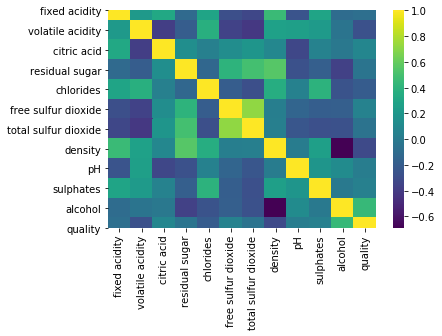

In [5]:
import seaborn as sns
sns.heatmap(corr, cmap='viridis')

### 선형회귀

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(winequalityN, test_size=0.2, random_state=2)
print(train.shape, test.shape)

train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape

(5197, 13) (1300, 13)


((4157, 13), (1040, 13))

In [7]:
target = 'quality'
feature = winequalityN.columns.drop([target])
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [8]:
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

linear = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),  
    LinearRegression()
)
                                     
linear.fit(X_train, y_train)

# 회귀계수
coefficients = linear.named_steps['linearregression'].coef_
pd.Series(coefficients, feature)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


type                    -0.370838
fixed acidity            0.058932
volatile acidity        -1.436759
citric acid              0.017115
residual sugar           0.052722
chlorides               -0.900286
free sulfur dioxide      0.005592
total sulfur dioxide    -0.001394
density                -81.073765
pH                       0.334508
sulphates                0.644006
alcohol                  0.243629
dtype: float64

### 분류 문제

In [9]:
# quality 가 6.5이상이면 Good으로 생각
winequalityN['recommend'] = winequalityN['quality'] >= 6.5
winequalityN['recommend'].value_counts()

False    5220
True     1277
Name: recommend, dtype: int64

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(winequalityN, test_size=0.2, random_state=2)
print(train.shape, test.shape)

train, val = train_test_split(train, test_size=0.2, random_state=2)
train.shape, val.shape

(5197, 14) (1300, 14)


((4157, 14), (1040, 14))

In [11]:
target = 'recommend'
feature = winequalityN.columns.drop([target,'quality'])
X_train = train[feature]
y_train = train[target]
X_val = val[feature]
y_val = val[target]
X_test = test[feature]
y_test = test[target]

In [12]:
# 그래디언트 부스팅
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

boosting = XGBClassifier(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:0.451514	validation_1-rmse:0.454108
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:0.417333	validation_1-rmse:0.422671
[2]	validation_0-rmse:0.39344	validation_1-rmse:0.401569
[3]	validation_0-rmse:0.376834	validation_1-rmse:0.388162
[4]	validation_0-rmse:0.364637	validation_1-rmse:0.377474
[5]	validation_0-rmse:0.356222	validation_1-rmse:0.370616
[6]	validation_0-rmse:0.349759	validation_1-rmse:0.364833
[7]	validation_0-rmse:0.344882	validation_1-rmse:0.360704
[8]	validation_0-rmse:0.34158	validation_1-rmse:0.358679
[9]	validation_0-rmse:0.338455	validation_1-rmse:0.356514
[10]	validation_0-rmse:0.336018	validation_1-rmse:0.3544
[11]	validation_0-rmse:0.33428	validation_1-rmse:0.352689
[12]	validation_0-rmse:0.332696	validation_1-rmse:0.351855
[13]	validation_0-rmse:0.331532	validation_1-rmse:0.351326
[14]	validation_0-rmse:0.33033

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='reg:squarederror', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

y_pred = boosting.predict(X_test_encoded)
print('검증 정확도: ', f1_score(y_test, y_pred))

print(classification_report(y_pred, y_test))

검증 정확도:  0.5681818181818182
              precision    recall  f1-score   support

       False       0.94      0.89      0.91      1112
        True       0.50      0.66      0.57       188

    accuracy                           0.85      1300
   macro avg       0.72      0.78      0.74      1300
weighted avg       0.88      0.85      0.86      1300



## 와인의 성분 (화이트, 레드 구분)

In [14]:
winequalityN

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,recommend
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6,False
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6,False
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6,False
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,False
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,False
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6,False
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,False
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,False


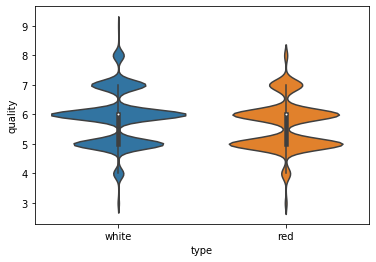

In [15]:
import seaborn as sns
sns.violinplot(data=winequalityN, x='type',y='quality')

In [16]:
condition=(winequalityN['type']=='red')

winequality_red=winequalityN[condition]
winequality_white=winequalityN[~condition]

print(len(winequality_red),len(winequality_white))

1599 4898


In [17]:
import scipy.stats as stats

F_statistic, pVal = stats.f_oneway(winequality_red['quality'],winequality_white['quality'])
print('데이터 일원분산분석 결과 : F={0:.5f}, p={1:0.5f}'.format(F_statistic, pVal))
if pVal<0.05:
  print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

데이터 일원분산분석 결과 : F=93.81181, p=0.00000
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


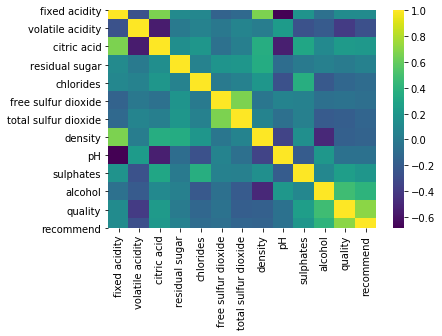

In [18]:
import seaborn as sns

corr_red=winequality_red.corr()
sns.heatmap(corr_red, cmap='viridis')

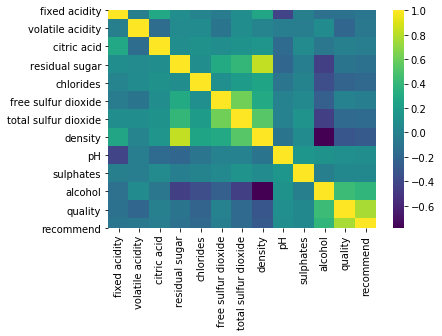

In [19]:
import seaborn as sns

corr_wh=winequality_white.corr()
sns.heatmap(corr_wh, cmap='viridis')

### regression

In [20]:
from sklearn.model_selection import train_test_split

# 레드 와인
train_red, test_red = train_test_split(winequality_red, test_size=0.2, random_state=2)
print(train_red.shape, test_red.shape)

train_red, val_red = train_test_split(train_red, test_size=0.2, random_state=2)
print(train_red.shape, val_red.shape)

target_red = 'quality'
feature_red = winequality_red.columns.drop([target_red,'type','recommend'])
X_train_red = train_red[feature_red]
y_train_red = train_red[target_red]
X_val_red = val_red[feature_red]
y_val_red = val_red[target_red]
X_test_red = test_red[feature_red]
y_test_red = test_red[target_red]

# 화이트 와인
train_wh, test_wh = train_test_split(winequality_white, test_size=0.2, random_state=2)
print(train_wh.shape, test_wh.shape)

train_wh, val_wh = train_test_split(train_wh, test_size=0.2, random_state=2)
print(train_wh.shape, val_wh.shape)

target_wh = 'quality'
feature_wh = winequality_white.columns.drop([target_wh,'type','recommend'])
X_train_wh = train_wh[feature_wh]
y_train_wh = train_wh[target_wh]
X_val_wh = val_wh[feature_wh]
y_val_wh = val_wh[target_wh]
X_test_wh = test_wh[feature_wh]
y_test_wh = test_wh[target_wh]

(1279, 14) (320, 14)
(1023, 14) (256, 14)
(3918, 14) (980, 14)
(3134, 14) (784, 14)


#### 레드 와인

In [21]:
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

linear_red = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),  
    LinearRegression()
)
                                     
linear_red.fit(X_train_red, y_train_red)

# 회귀계수
coefficients_red = linear_red.named_steps['linearregression'].coef_
pd.Series(coefficients_red, feature_red)

fixed acidity           0.015867
volatile acidity       -1.068935
citric acid            -0.154135
residual sugar         -0.007230
chlorides              -1.506909
free sulfur dioxide     0.004357
total sulfur dioxide   -0.003095
density                 3.584578
pH                     -0.281179
sulphates               0.876600
alcohol                 0.307394
dtype: float64

In [22]:
# 그래디언트 부스팅
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

boosting_red = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set_red = [(X_train_red, y_train_red), 
            (X_val_red, y_val_red)]

boosting_red.fit(X_train_red, y_train_red, 
          eval_set=eval_set_red,
          early_stopping_rounds=50
         )

y_pred_red = boosting_red.predict(X_test_red)
print('R^2', r2_score(y_test_red, y_pred_red))

[0]	validation_0-rmse:4.17299	validation_1-rmse:4.16069
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.36409	validation_1-rmse:3.35126
[2]	validation_0-rmse:2.71994	validation_1-rmse:2.70705
[3]	validation_0-rmse:2.209	validation_1-rmse:2.1999
[4]	validation_0-rmse:1.80565	validation_1-rmse:1.80139
[5]	validation_0-rmse:1.48921	validation_1-rmse:1.49723
[6]	validation_0-rmse:1.24191	validation_1-rmse:1.26296
[7]	validation_0-rmse:1.05213	validation_1-rmse:1.0873
[8]	validation_0-rmse:0.908342	validation_1-rmse:0.955955
[9]	validation_0-rmse:0.801312	validation_1-rmse:0.865505
[10]	validation_0-rmse:0.72353	validation_1-rmse:0.801514
[11]	validation_0-rmse:0.667106	validation_1-rmse:0.758449
[12]	validation_0-rmse:0.626759	validation_1-rmse:0.728399
[13]	validation_0-rmse:0.598841	validation_1-rmse:0.707759
[14]	validation_0-rmse:0.577662	validation_1-r

#### 화이트 와인

In [24]:
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

linear_wh = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),  
    LinearRegression()
)
                                     
linear_wh.fit(X_train_wh, y_train_wh)

# 회귀계수
coefficients_wh = linear_wh.named_steps['linearregression'].coef_
pd.Series(coefficients_wh, feature_wh)

fixed acidity             0.112419
volatile acidity         -2.036194
citric acid               0.041188
residual sugar            0.109438
chlorides                 0.542741
free sulfur dioxide       0.003893
total sulfur dioxide      0.000023
density                -228.798176
pH                        0.933895
sulphates                 0.625219
alcohol                   0.106144
dtype: float64

In [28]:
# 그래디언트 부스팅
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

boosting_wh = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set_wh = [(X_train_wh, y_train_wh), 
            (X_val_wh, y_val_wh)]

boosting_wh.fit(X_train_wh, y_train_wh, 
          eval_set=eval_set_wh,
          early_stopping_rounds=50
         )

y_pred_wh = boosting_wh.predict(X_test_wh)
print('R^2', r2_score(y_test_wh, y_pred_wh))


[0]	validation_0-rmse:4.39458	validation_1-rmse:4.36753
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:3.54516	validation_1-rmse:3.51859
[2]	validation_0-rmse:2.87134	validation_1-rmse:2.84634
[3]	validation_0-rmse:2.33872	validation_1-rmse:2.31751
[4]	validation_0-rmse:1.92102	validation_1-rmse:1.90084
[5]	validation_0-rmse:1.59586	validation_1-rmse:1.58111
[6]	validation_0-rmse:1.34484	validation_1-rmse:1.33355
[7]	validation_0-rmse:1.15512	validation_1-rmse:1.15154
[8]	validation_0-rmse:1.01302	validation_1-rmse:1.01719
[9]	validation_0-rmse:0.91032	validation_1-rmse:0.921904
[10]	validation_0-rmse:0.835486	validation_1-rmse:0.853741
[11]	validation_0-rmse:0.782933	validation_1-rmse:0.807556
[12]	validation_0-rmse:0.74651	validation_1-rmse:0.778452
[13]	validation_0-rmse:0.719718	validation_1-rmse:0.75643
[14]	validation_0-rmse:0.702014	validation_1-r

### classifier

In [29]:
train_red

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,recommend
5605,red,7.4,0.49,0.19,3.0,0.077,16.0,37.0,0.99660,3.37,0.51,10.5,5,False
5693,red,10.8,0.89,0.30,2.6,0.132,7.0,60.0,0.99786,2.99,1.18,10.2,5,False
6188,red,7.6,0.74,0.00,1.9,0.100,6.0,12.0,0.99521,3.36,0.59,11.0,5,False
5837,red,6.2,0.46,0.17,1.6,0.073,7.0,11.0,0.99425,3.61,0.54,11.4,5,False
6148,red,7.1,0.60,0.01,2.3,0.079,24.0,37.0,0.99514,3.40,0.61,10.9,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5494,red,12.4,0.40,0.51,2.0,0.059,6.0,24.0,0.99940,3.04,0.60,9.3,6,False
5441,red,11.2,0.66,0.24,2.5,0.085,16.0,53.0,0.99930,3.06,0.72,11.0,6,False
5582,red,9.8,0.98,0.32,2.3,0.078,35.0,152.0,0.99800,3.25,0.48,9.4,5,False
5569,red,8.2,0.73,0.21,1.7,0.074,5.0,13.0,0.99680,3.20,0.52,9.5,5,False


In [30]:
from sklearn.model_selection import train_test_split

# 레드 와인
train_red2, test_red2 = train_test_split(winequality_red, test_size=0.2, random_state=2)
print(train_red2.shape, test_red2.shape)

train_red2, val_red2 = train_test_split(train_red2, test_size=0.2, random_state=2)
print(train_red2.shape, val_red2.shape)

target_red2 = 'recommend'
feature_red2 = winequality_red.columns.drop([target_red2,'type','quality'])
X_train_red2 = train_red2[feature_red2]
y_train_red2 = train_red2[target_red2]
X_val_red2 = val_red2[feature_red2]
y_val_red2 = val_red2[target_red2]
X_test_red2 = test_red2[feature_red2]
y_test_red2 = test_red2[target_red2]

# 화이트 와인
train_wh2, test_wh2 = train_test_split(winequality_white, test_size=0.2, random_state=2)
print(train_wh2.shape, test_wh2.shape)

train_wh2, val_wh2 = train_test_split(train_wh2, test_size=0.2, random_state=2)
print(train_wh2.shape, val_wh2.shape)

target_wh2 = 'recommend'
feature_wh2 = winequality_white.columns.drop([target_wh2,'type','quality'])
X_train_wh2 = train_wh2[feature_wh2]
y_train_wh2 = train_wh2[target_wh2]
X_val_wh2 = val_wh2[feature_wh2]
y_val_wh2 = val_wh2[target_wh2]
X_test_wh2 = test_wh2[feature_wh2]
y_test_wh2 = test_wh2[target_wh2]

(1279, 14) (320, 14)
(1023, 14) (256, 14)
(3918, 14) (980, 14)
(3134, 14) (784, 14)


#### 레드 와인

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

pipe_decision_red = make_pipeline(
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe_decision_red.fit(X_train_red2, y_train_red2)
print('검증 정확도', pipe_decision_red.score(X_val_red2, y_val_red2))

검증 정확도 0.875


In [32]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

pipe_xgb_red = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe_xgb_red.fit(X_train_red2, y_train_red2);

In [34]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print('검증 정확도', pipe_xgb_red.score(X_val_red2, y_val_red2))

y_pred_red2 = pipe_xgb_red.predict(X_test_red2)
print('테스트 정확도: ', f1_score(y_test_red2, y_pred_red2))

print(classification_report(y_pred_red2, y_test_red2))

검증 정확도 0.90625
테스트 정확도:  0.6075949367088608
              precision    recall  f1-score   support

       False       0.95      0.94      0.94       282
        True       0.59      0.63      0.61        38

    accuracy                           0.90       320
   macro avg       0.77      0.79      0.78       320
weighted avg       0.91      0.90      0.90       320



In [40]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_red = PermutationImportance(
    pipe_xgb_red, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_red.fit(X_val_red2, y_val_red2);

In [41]:
feature_names_red = X_val_red2.columns.tolist()
pd.Series(permuter_red.feature_importances_, feature_names_red).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter_red, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names_red # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0445 ± 0.0153,alcohol
0.0430 ± 0.0275,sulphates
0.0164 ± 0.0194,total sulfur dioxide
0.0133 ± 0.0117,volatile acidity
0.0117 ± 0.0156,fixed acidity
0.0078 ± 0.0070,free sulfur dioxide
0.0047 ± 0.0058,density
0.0008 ± 0.0058,chlorides
-0.0008 ± 0.0125,citric acid
-0.0063 ± 0.0038,pH


In [43]:
print('특성 삭제 전:', X_train_red2.shape, X_val_red2.shape, X_test_red2.shape)

minimum_importance = 0.001
mask = permuter_red.feature_importances_ > minimum_importance
features = X_train_red2.columns[mask]
X_train_selected_red2 = X_train_red2[features]
X_val_selected_red2 = X_val_red2[features]
X_test_selected_red2 = X_test_red2[features]

print('특성 삭제 후:', X_train_selected_red2.shape, X_val_selected_red2.shape, X_test_selected_red2.shape)

특성 삭제 전: (1023, 11) (256, 11) (320, 11)
특성 삭제 후: (1023, 7) (256, 7) (320, 7)


In [46]:
pipe_xgb_red2 = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe_xgb_red2.fit(X_train_selected_red2, y_train_red2);

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print('검증 정확도', pipe_xgb_red2.score(X_val_selected_red2, y_val_red2))

y_pred_selected_red2 = pipe_xgb_red2.predict(X_test_selected_red2)
print('테스트 정확도: ', f1_score(y_test_red2, y_pred_selected_red2))

print(classification_report(y_pred_selected_red2, y_test_red2))

검증 정확도 0.921875
테스트 정확도:  0.6329113924050632
              precision    recall  f1-score   support

       False       0.95      0.94      0.95       282
        True       0.61      0.66      0.63        38

    accuracy                           0.91       320
   macro avg       0.78      0.80      0.79       320
weighted avg       0.91      0.91      0.91       320



#### 화이트 와인

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

pipe_decision_wh = make_pipeline(
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe_decision_wh.fit(X_train_wh2, y_train_wh2)
print('검증 정확도', pipe_decision_wh.score(X_val_wh2, y_val_wh2))

검증 정확도 0.8035714285714286


In [36]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

pipe_xgb_wh = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe_xgb_wh.fit(X_train_wh2, y_train_wh2);

In [37]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print('검증 정확도', pipe_xgb_wh.score(X_val_wh2, y_val_wh2))

y_pred_wh2 = pipe_xgb_wh.predict(X_test_wh2)
print('테스트 정확도: ', f1_score(y_test_wh2, y_pred_wh2))

print(classification_report(y_pred_wh2, y_test_wh2))

검증 정확도 0.8584183673469388
테스트 정확도:  0.6259946949602122
              precision    recall  f1-score   support

       False       0.93      0.89      0.91       809
        True       0.57      0.69      0.63       171

    accuracy                           0.86       980
   macro avg       0.75      0.79      0.77       980
weighted avg       0.87      0.86      0.86       980



In [47]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_wh = PermutationImportance(
    pipe_xgb_wh, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter_wh.fit(X_val_wh2, y_val_wh2);

In [48]:
feature_names_wh = X_val_wh2.columns.tolist()
pd.Series(permuter_wh.feature_importances_, feature_names_wh).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter_wh, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names_wh # list 형식으로 넣어야 합니다
)

# feature 값 모두 0.001 보다 큼, 특성 모두 사용

Weight,Feature
0.0408 ± 0.0187,alcohol
0.0311 ± 0.0103,volatile acidity
0.0268 ± 0.0108,residual sugar
0.0232 ± 0.0116,density
0.0219 ± 0.0109,pH
0.0214 ± 0.0083,free sulfur dioxide
0.0207 ± 0.0030,fixed acidity
0.0168 ± 0.0179,total sulfur dioxide
0.0122 ± 0.0108,citric acid
0.0120 ± 0.0047,sulphates
